# Introduction
This notebook can be used to: 
1. visualize training data
2. visualize prediction of a model

In [5]:
import os, sys
import torch, json
import numpy as np
import re
import torch.nn as nn
from main_synthetic import build_model_main
from util.slconfig import SLConfig
import editdistance
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
import editdistance


# Training Data 

## Synthetic data
Synthetic data are saved in **/datasets/synthetic_**. We advice to use the following code to / visualize the data augmentation used during training and the bouding boxes

In [34]:
model_config_path = "config/Latin.py" # change the path of the model config file
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda:0' 
args.coco_path = "/comp_robot/cv_public_dataset/COCO2017/" # the path of coco
args.fix_size = False

### Latin
change **args.language = 'en'** to specify either french, english, or german. Comment for random characters

In [30]:
args.dataset_file = 'synthetic_line_OCR_general'
args.language = 'en' # comment for general
args.random_erasing = True

dataset_val = build_dataset(image_set='train', args=args) 

USING language: en 


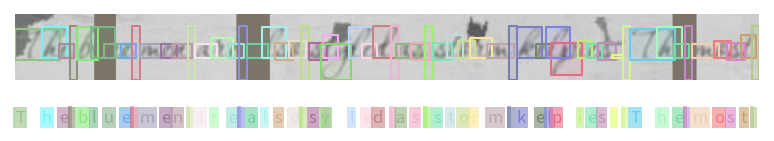

In [33]:
i = np.random.randint(0, len(dataset_val))
image, targets = dataset_val[i]
boxes = targets['boxes']



box_label = [dataset_val.charset[int(item)] for item in targets['labels']] # chinese character are encoded in unicode
pred_dict = {
'boxes': boxes,
'size': torch.tensor([image.shape[-2], image.shape[-1]]),
'box_label': box_label,
'image_id': 0

}
vslzr = COCOVisualizer()
vslzr.visualize(image, pred_dict,  show_in_console=True,fontsize =8, offset=120,dpi = 150,Chinese=True)


### Chinese

In [14]:
args.dataset_file = 'HWDB_synth' ## change the dataset file
args.random_erasing = True

dataset_val = build_dataset(image_set='train', args=args)  

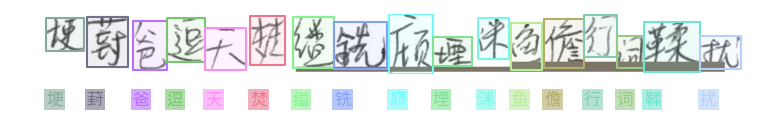

In [26]:
i = np.random.randint(0, len(dataset_val))
image, targets = dataset_val[i]
boxes = targets['boxes']



box_label = [chr(dataset_val.charset[int(item)]) for item in targets['labels']] # chinese character are encoded in unicode
pred_dict = {
'boxes': boxes,
'size': torch.tensor([image.shape[-2], image.shape[-1]]),
'box_label': box_label,
'image_id': 0

}
vslzr = COCOVisualizer()
vslzr.visualize(image, pred_dict,  show_in_console=True,fontsize =8, offset=120,dpi = 150,Chinese=True)


## Real Datasets
Real datasets are expected to be stored in the folder indicated in datasets/config.json. We advice to use the following code to visualize the random erasing, in particular for a custom dataset. 
Real datasets have no annotations for the bouding boxes, only lines transcription

In [35]:
model_config_path = "config/Latin.py" # change the path of the model config file
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda:0' 
args.coco_path = "/comp_robot/cv_public_dataset/COCO2017/" # the path of coco
args.fix_size = False

Change args.dataset_file 

In [44]:
args.dataset_file = 'HWDB' ## change the dataset file
dataset_val = build_dataset(image_set='train', args=args)  

train


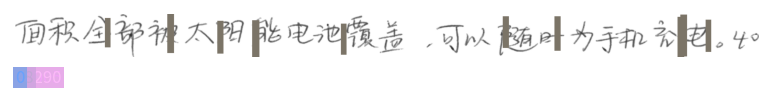

面积全部被太阳能电池覆盖, 可以随时为手机充电。4 0 


In [50]:
i = np.random.randint(0, len(dataset_val))
image, targets = dataset_val[i]
boxes = targets['boxes']



box_label = [dataset_val.charset[int(item)] for item in targets['labels']] # chinese character are encoded in unicode

pred_dict = {
'boxes': boxes,
'size': torch.tensor([image.shape[-2], image.shape[-1]]),
'box_label': box_label,
'image_id': 0

}
vslzr = COCOVisualizer()
vslzr.visualize(image, pred_dict,  show_in_console=True,fontsize =8, offset=120,dpi = 150,Chinese=True)
try:
    str_gt = ''.join(box_label)
except:
    # for HWDB dataset
    box_label = [chr(dataset_val.charset[int(item)]) for item in targets['labels']]
    str_gt = ''.join(box_label)
print(str_gt)

# Visualize the prediction of a model

In [103]:
args.coco_path = "/comp_robot/cv_public_dataset/COCO2017/" # the path of coco
args.fix_size = False
args = SLConfig.fromfile(model_config_path) 
device = args.device = 'cuda:0' 

Change the following: **weight** and **dataset**

In [104]:
pretrained_model = True
model_config_path = "config/Latin_CTC.py" # change the path of the model config file
model_checkpoint_path =  "/home/rbaena/projects/OCR/n-gram/RIMES_w_w/checkpoint.pth"
args.dataset_file = 'RIMES' # change the dataset file


In [105]:

dataset_val = build_dataset(image_set='test', args=args)   

In [106]:
charset = dataset_val.charset
model, criterion, postprocessors = build_model_main(args)

checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
try:
     model.load_state_dict(checkpoint['model'])
except:
    features_dim = model.class_embed[0].weight.data.shape[1]
    new_charset_size = len(charset)
    new_class_embed = nn.Linear(features_dim,new_charset_size ,)
    new_decoder_class_embed = nn.Linear(features_dim,new_charset_size ,)
    new_enc_out_class_embed = nn.Linear(features_dim,new_charset_size ,)
    if model.dec_pred_class_embed_share:
        class_embed_layerlist = [new_class_embed for i in range(model.transformer.num_decoder_layers)]

        new_class_embed = nn.ModuleList(class_embed_layerlist)
        model.class_embed = new_class_embed.to(device)
        model.transformer.decoder.class_embed = new_decoder_class_embed.to(device)
        model.transformer.enc_out_class_embed = new_enc_out_class_embed.to(device)
        try:
            checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
            model.load_state_dict(checkpoint['model'])
        except:
            model.label_enc = nn.Embedding(len(dataset_val.charset)+1,features_dim ).to(device)
            checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
            model.load_state_dict(checkpoint['model'])

model.eval()
model.to(device)

DINO(
  (transformer): DeformableTransformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      

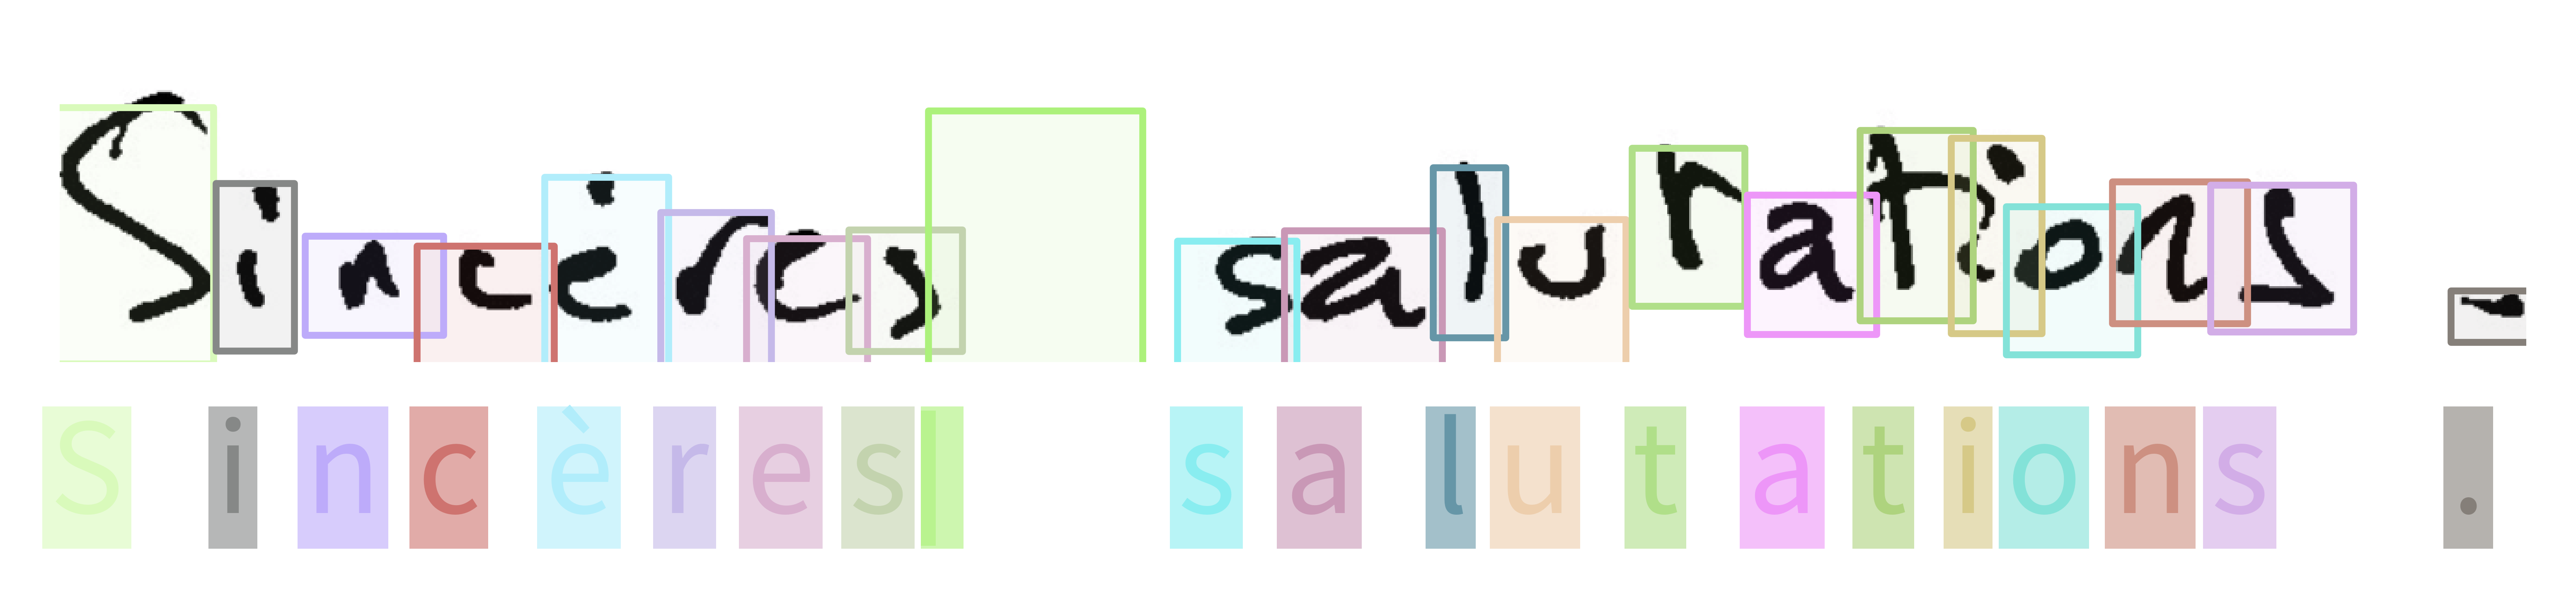

pt:  Sincères salutations.
gt:  Sincères salutations.
CER:  0.0


In [107]:
i = 203
image, targets = dataset_val[i]

with torch.no_grad():
    model.eval()
    output = model.to(device)(image[None].to(device))

    postprocessors['bbox'].num_select = 900
    postprocessors['bbox'].nms_iou_threshold = 0.3
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

    thershold = 0.3#

    scores = output['scores']
    labels = output['labels']

    
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > thershold
    indices_sort = boxes[select_mask][:,0].sort()[1]
    box_label = []
    try:
        try:
            box_label = [chr(dataset_val.charset[int(item)]) for item in labels[select_mask][indices_sort]]
        except:
            box_label = [dataset_val.charset[int(item)] for item in labels[select_mask][indices_sort]]
    except:
        try:
            box_label = [chr(charset[int(item)]) for item in labels[select_mask][indices_sort]]
        except:
            box_label = [charset[int(item)] for item in labels[select_mask][indices_sort]]

    pred_dict = {
    'boxes': boxes[select_mask][indices_sort],
    'size': torch.tensor([image.shape[-2], image.shape[-1]]),
    'box_label': box_label,
    'image_id': 0
    
}
    vslzr = COCOVisualizer()
    vslzr.visualize(image, pred_dict,  show_in_console=True,fontsize =18, offset=120, savedir ='/home/rbaena/projects/OCR/Copiale.jpg',dpi = 1200,Chinese=True)
str_pred = "".join(box_label)
str_pred = str_pred.replace("","")
print('pt: ',str_pred)
try:
    str_gt = "".join([chr(dataset_val.charset[item]) for item in targets['labels']])
except:
    str_gt = "".join([dataset_val.charset[item] for item in targets['labels']])
print('gt: ',str_gt)
CER = editdistance.eval(str_pred,str_gt)/ len(str_gt)
print('CER: ',CER)
